
LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x35b1cb0a0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x124d76d60>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <__main__.CustomDense object at 0x125c9ab80>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Shape of step_w: (784, 1)

LAYER 3: <__main__.CustomDense object at 0x125ce5250>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Shape of step_w: (128, 1)
Epoch 1/5
1853/1875 [============================>.] - ETA: 0s - loss: 17149.8047 - accuracy: 0.3757
Epoch 1: 
Average scale value of w: 4.755916595458984, 
Loss: 16948.884765625, 
Accuracy: 0.379966676235199

Epoch 1: 
Average scale value of w: 6.865415573120117, 
Loss: 16948.884765625, 
Accuracy: 0.379966676235199
1875/1875 [==============================] - 4s 2ms/step - loss: 16948.8848 - accuracy: 0.3800 - val_los

/var/folders/ms/xd16k27j2lj0dx3xp_nqkcgr0000gn/T/ipykernel_128/3942018252.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


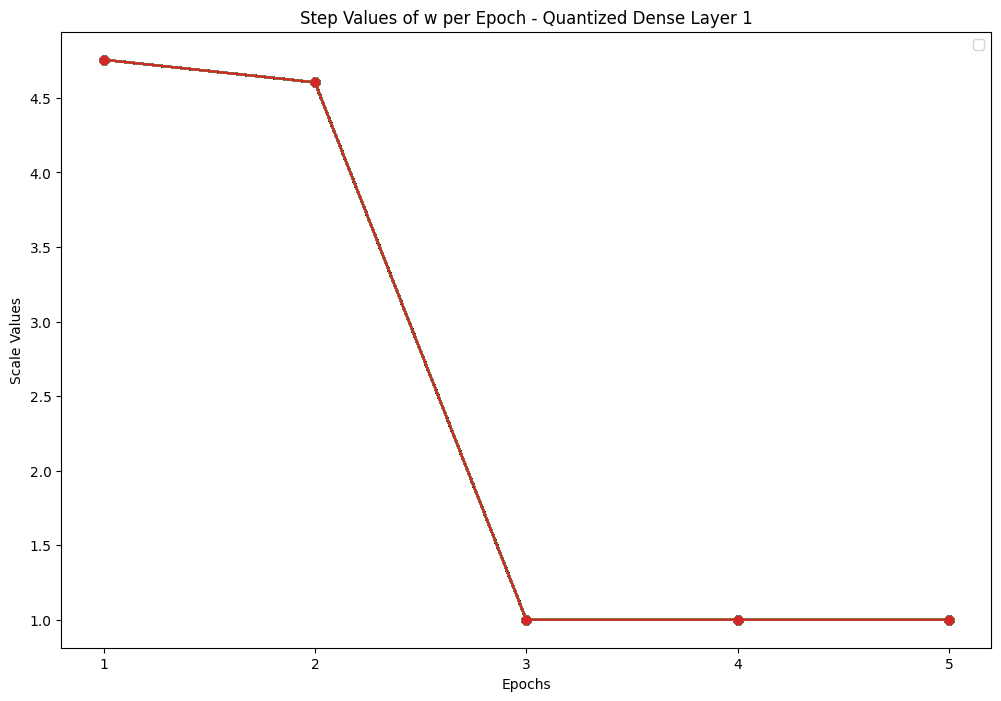

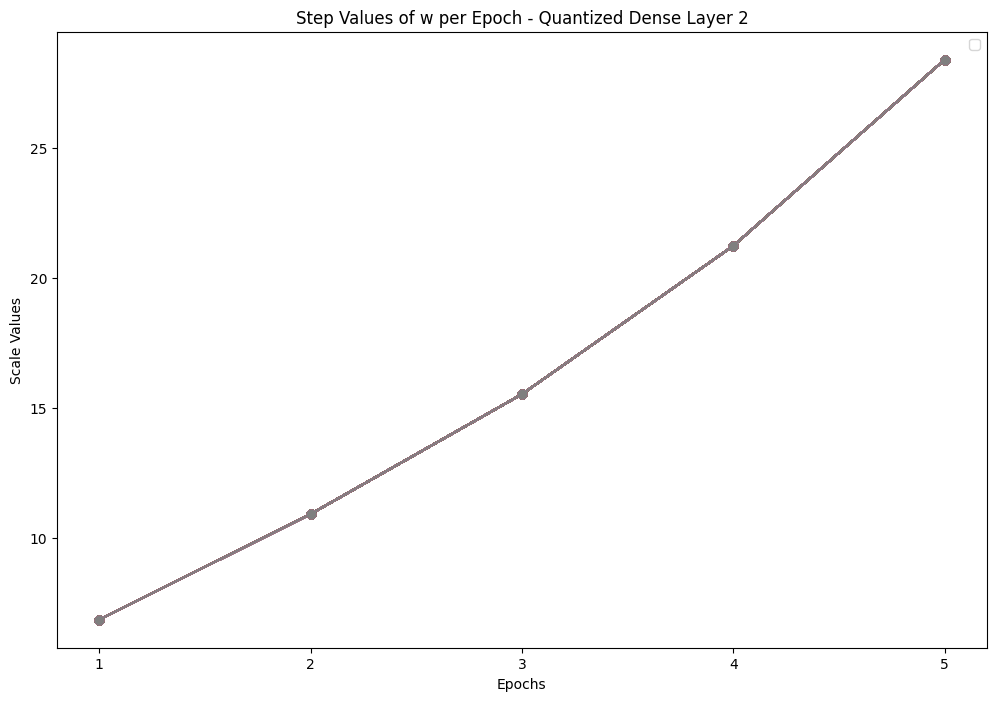

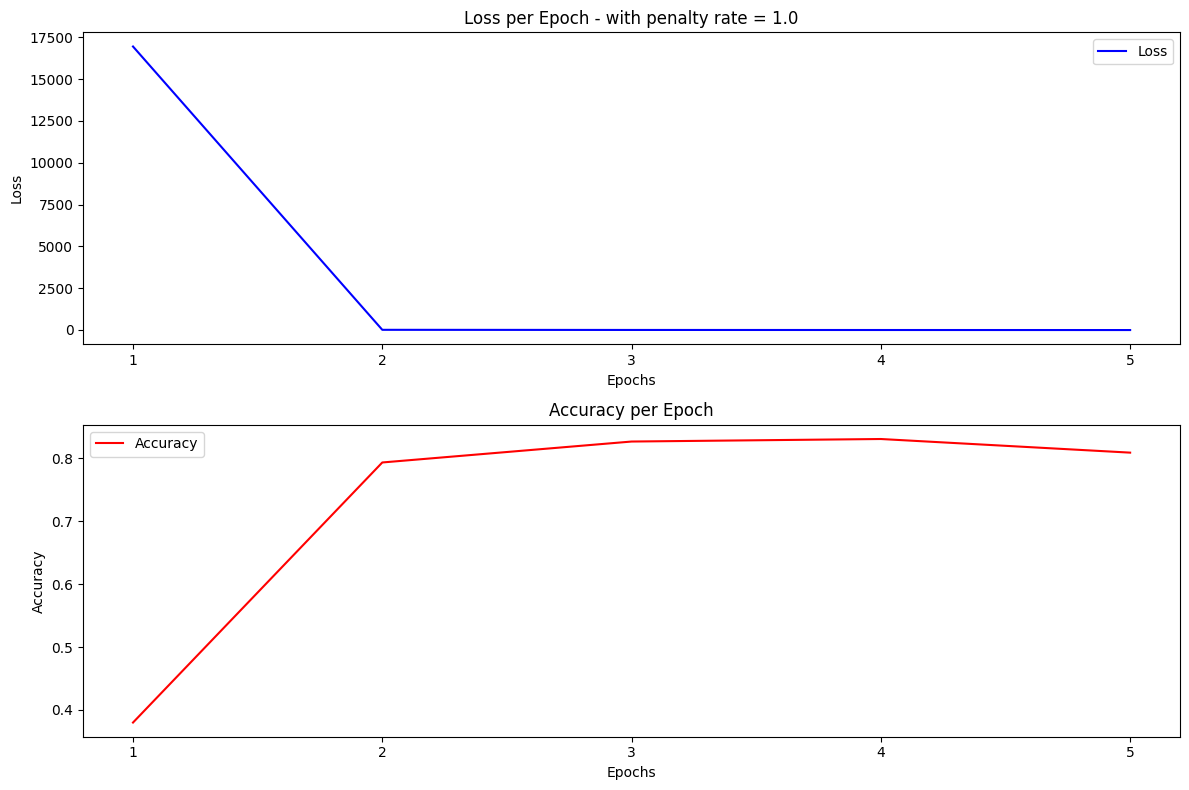

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

eps_float32 = np.finfo(np.float32).eps

class ScaleTrackingCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer):
        super(ScaleTrackingCallback, self).__init__()
        self.layer = layer
        self.scale_values_per_epoch_w = []
        self.average_scale_values_w = []

        self.epoch_loss = []
        self.epoch_accuracy = []
        self.num_epochs = 0

    def on_epoch_end(self, epoch, logs=None):
        scale_values_w = self.layer.step_w.numpy().flatten()
        self.scale_values_per_epoch_w.append(scale_values_w)
        average_scale_value_w = np.mean(scale_values_w)
        self.average_scale_values_w.append(average_scale_value_w)

        self.epoch_loss.append(logs['loss'])
        
        self.epoch_accuracy.append(logs['accuracy'])
        print(f"\nEpoch {epoch+1}: \nAverage scale value of w: {average_scale_value_w}, \nLoss: {logs['loss']}, \nAccuracy: {logs['accuracy']}")

        # Save losses to file
        with open("loss_data.txt", 'a') as f:
            f.write(f"Epoch {epoch+1}, Total Loss: {logs['loss']}\n")


    def plot_scale_values(self, layer_name):
        plt.figure(figsize=(12, 8))

        # Plot each scale value trajectory
        for i in range(len(self.scale_values_per_epoch_w[0])):
            scale_trajectory = [epoch[i] for epoch in self.scale_values_per_epoch_w]
            plt.plot(range(1, len(self.scale_values_per_epoch_w) + 1), scale_trajectory, linestyle='-', marker='o')

        # Plot the average scale values
        #plt.plot(range(1, len(self.average_scale_values) + 1), self.average_scale_values, label='Average Scale Value', color='red', linewidth=2)

        plt.xlabel('Epochs')
        plt.ylabel('Scale Values')
        plt.title('Step Values of w per Epoch - ' + layer_name)
        plt.xticks(range(1, len(self.average_scale_values_w) + 1))  
        plt.legend()
        plt.show()


    def plot_loss_accuracy(self, penalty_rate):
        epochs = range(1, len(self.epoch_loss) + 1)

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(epochs, self.epoch_loss, 'b-', label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss per Epoch - with penalty rate = ' + penalty_rate)
        plt.xticks(range(1, len(self.average_scale_values_w) + 1))  
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, self.epoch_accuracy, 'r-', label='Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy per Epoch')
        plt.xticks(range(1, len(self.epoch_accuracy) + 1))  
        plt.legend()

        plt.tight_layout()
        plt.show()

# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1)  # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)


class MinValueConstraint(tf.keras.constraints.Constraint):
    def __init__(self, min_value):
        self.min_value = min_value

    def __call__(self, w):
        return tf.maximum(w, self.min_value)

    def get_config(self):
        return {'min_value': self.min_value}


class CustomDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(CustomDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer=tf.keras.initializers.Constant(5.0), 
            trainable=True
        )
        self.b = self.add_weight(
            shape=(self.units,),
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=2.0),  # Adjusted stddev
            trainable=True
        )
        self.step_w = self.add_weight(shape=(input_shape[-1], 1), initializer="ones", trainable=True, constraint=MinValueConstraint(1.0))

    def call(self, inputs):
        scaled_w = self.w / self.step_w
        quantized_w = tf.stop_gradient(tf.round(scaled_w))
        output = tf.matmul(inputs, quantized_w) + self.b

        if self.activation is not None:
            output = self.activation(output)
        return output

    def get_steps(self):
        return self.step_w


def custom_loss_sebastian(y_true, y_pred, bin_steps_of_layers, weights, penalty_rate):
    cross_entropy_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    
    # small epsilon to avoid division by zero
    epsilon = eps_float32
    scale_penalty = 0
    
    for (step_w, w) in zip(bin_steps_of_layers, weights):
        max_w = tf.reduce_max(w, axis=1) #absolute max value in w in each row
        
        max_w_quantized = (max_w / (tf.abs(step_w) + epsilon))

        scale_penalty += tf.reduce_mean(max_w_quantized)
    
    total_loss = cross_entropy_loss + penalty_rate * scale_penalty
    
    return total_loss


input_layer = tf.keras.layers.Input(shape=(28, 28, 1))
flatten_layer = tf.keras.layers.Flatten()(input_layer)
dense_layer1 = CustomDense(128, activation='relu')(flatten_layer)
dense_layer2 = CustomDense(10, activation='softmax')(dense_layer1)

custom_dense_model = tf.keras.Model(inputs=input_layer, outputs=dense_layer2)

# Print layer details
for i, layer in enumerate(custom_dense_model.layers):
    print(f"\nLAYER {i}: {layer}")
    print(f"  - Input Shape: {layer.input_shape}")
    print(f"  - Output Shape: {layer.output_shape}")
    if hasattr(layer, 'get_steps'):
        print(f"  - Shape of step_w: {layer.get_steps().shape}")


penalty_rates = [#0.0, 
                 #0.5, 
                 1.0, 
                 #10.0
                 ]

for penalty_rate in penalty_rates:

    # Compile and train the model
    custom_dense_model.compile(
        optimizer=Adam(learning_rate=0.01),
#        loss=custom_loss,
        loss=lambda y_true, y_pred: custom_loss_sebastian(y_true, y_pred, 
                                        [custom_dense_model.get_layer(index=2).get_steps(), 
                                        custom_dense_model.get_layer(index=3).get_steps()],
                                        [custom_dense_model.get_layer(index=2).w,
                                        custom_dense_model.get_layer(index=3).w],
                                        penalty_rate=penalty_rate),                                      
        metrics=['accuracy']
    )

    scale_tracking_callback_dense_layer1 = ScaleTrackingCallback(custom_dense_model.get_layer(index=2))
    scale_tracking_callback_dense_layer2 = ScaleTrackingCallback(custom_dense_model.get_layer(index=3))

    custom_dense_model.fit(
        x_train, y_train,
        epochs=5,
        validation_data=(x_test, y_test),
        callbacks=[scale_tracking_callback_dense_layer1, scale_tracking_callback_dense_layer2]
    )

    loss, accuracy = custom_dense_model.evaluate(x_test, y_test)
    print(f'Custom Dense Model Test Accuracy: {accuracy}')

    scale_tracking_callback_dense_layer1.plot_scale_values(layer_name="Quantized Dense Layer 1")
    scale_tracking_callback_dense_layer2.plot_scale_values(layer_name="Quantized Dense Layer 2")
    scale_tracking_callback_dense_layer2.plot_loss_accuracy(penalty_rate=f"{penalty_rate}")

